# **MobileNetV2-Cars-Classifier**

Cars Classifier Using Transfer Learning with MobileNetV2 trained on Cars Dataset bassed Stanford https://www.kaggle.com/datasets/boulahchichenadir/algerian-used-cars


### 1. Import Packages

Import the required packages

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tflbase_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

### 2. Load Dataset

Dataset used is uploaded on kaggle : [Download Dataset](https://www.kaggle.com/datasets/boulahchichenadir/algerian-used-cars)  
Dataset contains JPG Images of 20 class of Cars

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = '/content/drive/MyDrive/Master/Asignaturas/4 - Aprendizaje Profundo AP/mbnv2/dataset/'

train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42,
                                             label_mode='categorical')

validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42,
                                             label_mode='categorical')

Found 3235 files belonging to 20 classes.
Using 2588 files for training.
Found 3235 files belonging to 20 classes.
Using 647 files for validation.


### 3. Augment and Preprocess the Data

Our dataset is small, even for transfer learning, so data augmentation is needed.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [16]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation

In [17]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

### 4. Build and Train the Model

#### Build the Model

Define the cars_model and use the MobileNetV2

Freeze all the layers before the `fine_tune_at` layer.

In [18]:
def cars_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter(), fine_tune_at=120):
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')

    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    inputs = tf.keras.Input(shape=input_shape) 
    x = data_augmentation(inputs)
    x = preprocess_input(x) 

    x = base_model(x, training=False) 

    x = tfl.GlobalAveragePooling2D()(x) 
    x = tfl.Dropout(0.2)(x)

    # prediction_layer = tfl.Dense(1, activation = 'sigmoid')

    prediction_layer = tfl.Dense(20,activation=('softmax'))
    
    outputs = prediction_layer(x) 
    model = tf.keras.Model(inputs, outputs)
    
    return model

#### Set the Hyperparameters

There are 3 important parameters:-
* learning_rate
* epochs
* fine_tune_at :  
    Train (unfreeze) all the layers after this layer, i.e freeze all te layers before this layer.

Get the number of layers in the base model (MobileNetV2) excluding softmax layer, for setting the 'fine_tune_at' paramater

In [19]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE + (3,),
                                                   include_top=False,
                                                   weights='imagenet')
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [20]:
learning_rate = 0.0001
fine_tune_at = 120
epochs = 15
data_augmentation = data_augmenter()

#### Compile and Train the Model

In [21]:
model = cars_model(IMG_SIZE, data_augmentation, fine_tune_at)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

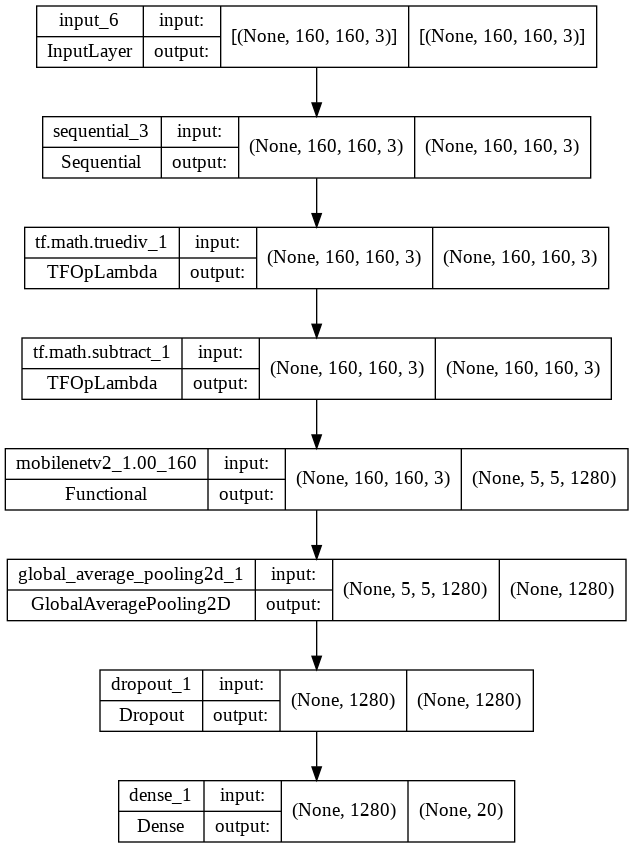

In [22]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=['accuracy'])

model_train = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


81/81 [==============================] - 218s 3s/step - loss: 2.8765 - accuracy: 0.1321 - val_loss: 2.5928 - val_accuracy: 0.2504
Epoch 2/15
81/81 [==============================] - 69s 841ms/step - loss: 2.5359 - accuracy: 0.2276 - val_loss: 2.3945 - val_accuracy: 0.2720
Epoch 3/15
81/81 [==============================] - 68s 839ms/step - loss: 2.1963 - accuracy: 0.3238 - val_loss: 1.8162 - val_accuracy: 0.4173
Epoch 4/15
29/81 [=========>....................] - ETA: 38s - loss: 1.9952 - accuracy: 0.4062

### 5. Plot the Accuracy and Loss

In [ ]:
acc = [0.] + model_train.history['accuracy']
val_acc = [0.] + model_train.history['val_accuracy']

loss = model_train.history['loss']
val_loss = model_train.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 6. Predictions

Test the predictions made by the Cars Model on validation set.

In [ ]:
class_names = validation_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in validation_dataset.take(1):
    image_var = tf.Variable(images)
    pred = model.predict(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        p = "cars" if pred[i] < 0 else "not cars"
        plt.title("pred:{} label:{}".format(p,class_names[labels[i]]))
        plt.axis("off")

In [ ]:
from keras.applications import mobilenet_v2
class_names = validation_dataset.class_names
plt.figure(figsize=(13, 13))
for images, labels in validation_dataset.take(1):
    image_var = tf.Variable(images)
    preds = model.predict(images)
    labels_numpy = labels.numpy()


    # print(preds.argsort()[-20:][::-1])
    # print(preds.argsort()[::-1]) me da el array ordenado, primer indice es el que va
    print(labels[0]) # me da el array con 1 en el que va
    print(preds.argsort()[::-1][0][0]) # la clase
    
    print(preds.argsort()[::-1][0])
    # print(preds[1])
    
    for i in range(9):
      pred_order = preds.argsort()[::-1][i][0]
      print(class_names[pred_order])
      print(labels_numpy.argsort()[::-1][i])
      print(class_names[labels_numpy[i]])
      # for label in labels_numpy:
      #   count = count + 1
      #   if label[i] == 1. :
      #       print(count, valor

      # print(class_names[labels_numpy.argsort()[::-1][i][0]])

      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title("pred:{} label:{}".format(pred_order,
                                          class_names[pred_order]))
      plt.axis("off")

    # for i in range(9):
    #     ax = plt.subplot(3, 3, i + 1)
    #     plt.imshow(images[i].numpy().astype("uint8"))

    #     p = "alpaca" if pred[i] < 0 else "not alpaca"
    #     plt.title("pred:{} label:{}".format(p,class_names[labels[i]]))
    #     plt.axis("off")

In [ ]:

labels_numpy = labels.numpy()
# print(labels_numpy[0][0])
# print(labels_numpy[0])
valores = []

for example in labels_numpy:
  count = 0
  # print(count, example)
  for valor in example:
      count = count + 1
      if valor == 1. :
          valores.append(count, valor)
          print(count, valor)
# return count, valor
  # for label in example:
  #   #if label is 0:
  #     print(label)



In [ ]:
print(labels_numpy.argsort()[::-1][0])